**GOAL OF THE NOTEBOOK:** To solve the Grid world challenge using `ACtor-critic` method which is a policy based learning method.

Here, we don't have a seperate value-based baselining method and a policy to choose the appropriate action based on the value.

We only have a directly probability attribution system to a specific action at a given state.

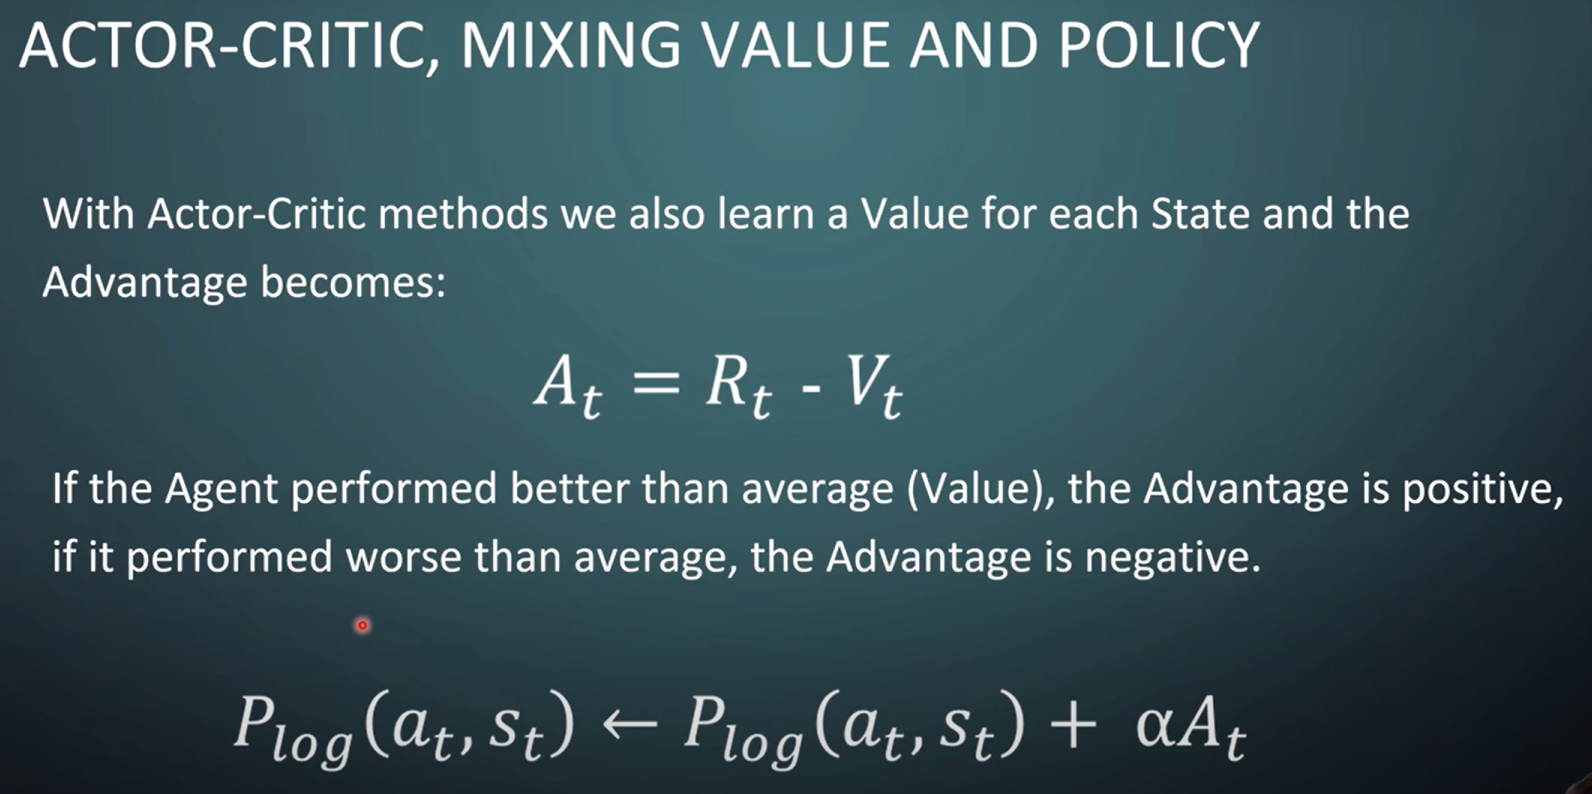

Here, the difference bewteen the current return values and average return values (Value term) are the advantage term that gives us an understanding of how close are we to the given goal state.

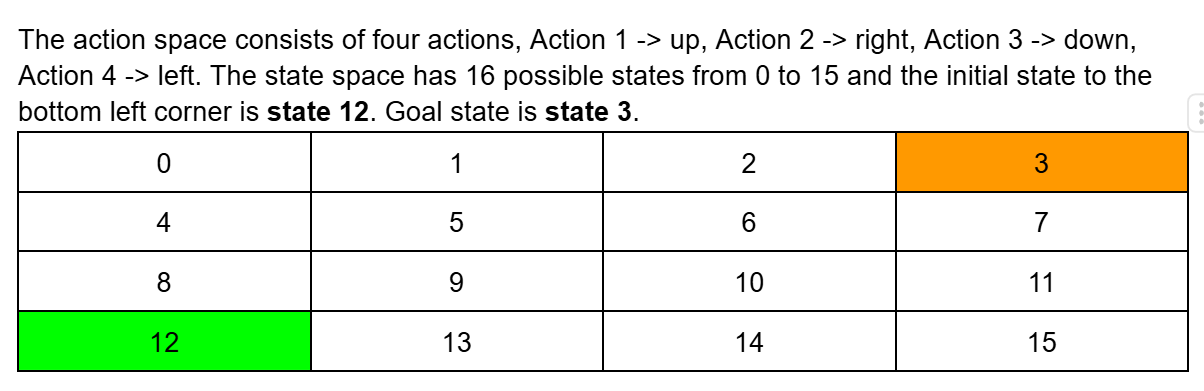

* State 12 is the initial state.
* State 3 is the goal state or the reward state.


## Imports

In [116]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import softmax

## Reward function definition

In [117]:
rewards = np.zeros(16)
rewards[3] = 10 # HIGH POSITIVE REWARD
rewards[2] = -5# NEGATIVE REWARDS
rewards[11] = -5
rewards[10] = -5


terminal_state = 3

# Q_values = np.zeros((16,4)) # Initializing Q-values
# # This is the Q-value - Action table. So, we are mapping ourselves, which action causes which transition using this table.
# # Slowly, we understand these and then navigate through the state action pairs that are associated with higher Q-values.
# # No of possible states = 16. No of possible actions = 4. So this table is of the shape (16,4)


# We don't need seperate Q-values any more.
state_action_logprobs = np.random.random((16,4))
# We are initializing a (16,4) table like Q-Learning with random probability values between 0 and 1.

state_values = np.zeros(16)

alpha = 0.005
score_log = []

In [118]:
rewards

array([ 0.,  0., -5., 10.,  0.,  0.,  0.,  0.,  0.,  0., -5., -5.,  0.,
        0.,  0.,  0.])

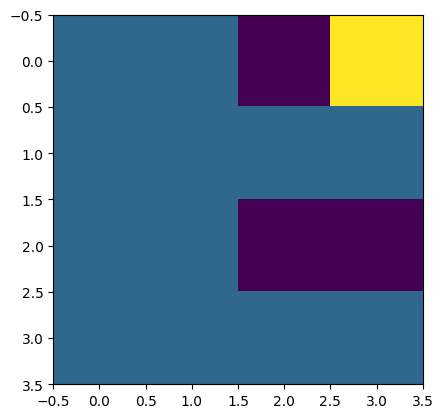

In [119]:
plt.imshow(rewards.reshape(4,4))

## State transition table

The following is our state transition table. We have 16 possible states in total from 0 to 15 and this table respresents how all the possible actions ie., Four actions 1 -> up, 2 -> right, 3 -> down, 4-> left affect the state transitions.

We are still having the state transition table for us to understand how the environment is being modelled. However, the agent policy in our code doesn't use this state transition table in any step to decide the action it is going to take.

In [120]:
file_path = "/content/drive/MyDrive/Colab_Notebooks/Reinforcement_Learning_notebooks/Grid_world_example/state_transitions.csv"
state_transition_table = np.genfromtxt(file_path, delimiter=",").astype(int)

In [121]:
state_transition_table

array([[ 0,  1,  4,  0],
       [ 1,  2,  5,  0],
       [ 2,  3,  6,  1],
       [ 3,  3,  7,  2],
       [ 0,  5,  8,  4],
       [ 1,  6,  9,  4],
       [ 2,  7, 10,  5],
       [ 3,  7, 11,  6],
       [ 4,  9, 12,  8],
       [ 5, 10, 13,  8],
       [ 6, 11, 14,  9],
       [ 7, 11, 15, 10],
       [ 8, 13, 12, 12],
       [ 9, 14, 13, 12],
       [10, 15, 14, 13],
       [11, 15, 15, 14]])

In [122]:
state_transition_table[0]

array([0, 1, 4, 0])

## Estimating the returns using future state values.

We use the TD method to compute the values for this actor-critic learning method. We can use any of the above value estimation method to compute the value in Actor-critic methods.

We can see that in time-difference method, we don't need to compute the discounted rewards at all as we will not need all the returns of the entire trajectory.

This method involves taking state values from the future time steps and estimating values close to the average return values from the future time step.

In [123]:
def returns_calc(rewards): # We are not using values yet
    returns = [] # Initialize an empty returns for this trajectory
    R = 0  # Initialize the return grid values for the respective trajectory
    gamma = 0.9
    for i in reversed(range(len(rewards))): # Gives the iteration from last reward to first reward
        R = rewards[i] + gamma * R
        returns.insert(0,R) # We are inserting before to ensure that the returns of the grid cell are associated in the same order and not the reverse order

    return returns

In [124]:
def TD_update(next_val, values, rewards, states):
    gamma = 0.9
    next_val = next_val
    #fixed bug in code here
    new_values = np.zeros(16) + values
    for i in reversed(range(len(rewards))):
        new_values[states[i]] = values[states[i]] + alpha * (rewards[i] + gamma * next_val - values[states[i]])
        next_val = values[states[i]]
    return new_values

## Test agent (single trajectory)

test_agent() describes a single trajectory that happens during test time.

The entire work flow would be:
1. Have a reward function
2. Training: Set multiple trajectories and give returns values to every single trajectory. Also assign values to states based on the average values of rewards in each trajectory.
3. Test time: Now, we have values of all the states and we just traverse our test agent by selecting the next state with the highest value from the state transition matrix.

In [125]:
def test_agent():
    state = 12 #  Starting with Initial state
    done = False
    steps = 0
    total_rewards = 0
    states_log = []
    while (not(state == terminal_state)) and steps<30:
        states_log.append(state) # log the current state
        action = np.argmax(np.random.multinomial(1, softmax(state_action_logprobs[state]), size=1))
        # action = np.argmax(softmax(state_action_logprobs[state]))

        # Taking the softmax of all the log probs of all actions in the given state.
        # IMP: We are using np.random.multinomial to give us a one hot encoder of selected action from all the actions
        # We are using a random selection rather than taking the max probable action because
        # in a more complicated problem, we might not know what action to take for sure
        # So, here we are demonstrating an idea of taking random action at test time which might prove useful.

        state = state_transition_table[state, action] # Updating state based on the action taken
        total_rewards += rewards[state]
        steps += 1
    states_log.append(state)
    return total_rewards, states_log # returns total rewards collected along the trajectory and a log of states and their transitions

## Training loop over multiple trajectories

We get returns grids for every single trajectory. A return grid is nothing but the return value of every cell in one trajectory. If we haven't touched that particular cell in the trajectory, the return grid's corresponding value to the respective cell would be 0.

In [126]:
number_of_trajectories = 1000

for _ in range(number_of_trajectories):
    state = 12 # Starting with the initial state
    state_log = []
    reward_log = []
    action_log = []
    values_log = []

    steps = 0

    # This while logic to finish the current trajectory from the initial position to the goal state
    while (not(state == terminal_state)) and steps<30:
        action = np.argmax(np.random.multinomial(1, softmax(state_action_logprobs[state]), size=1))
        # Taking the softmax of all the log probs of all actions in the given state.
        # IMP: We are using np.random.multinomial to give us a one hot encoder of selected action from all the actions
        # We are using a random selection rather than taking the max value to ensure exploration

        state_log.append(state) # log the current state
        values_log.append(state_values[state])
        action_log.append(action) # Log the current action

        state = state_transition_table[state, action] # Updating state based on the action taken
        reward_log.append(rewards[state])
        steps += 1


    next_val = state_values[state]

    state_values = TD_update(next_val, state_values, reward_log, state_log)
    state_returns = returns_calc(reward_log)

    advantage = np.subtract(state_returns,values_log)

    state_action_logprobs[state_log, action_log] = state_action_logprobs[state_log, action_log] + \
                                                alpha*advantage

    state_action_logprobs -= -0.001 * state_action_logprobs # squishes the distribution a little, adding some value to -ve and sub from +ve
    #state_action_logprobs = np.clip(state_action_logprobs, -5, 5)

    score_log.append(test_agent()[0]) # score is the reward that the test agent gets in the trajectory, which is nothing but cumulative rewards across the trajectory.

In [127]:
state_log # These are the state values at the respective time steps in the final trajectory

[12, 8, 9, 5, 6, 7]

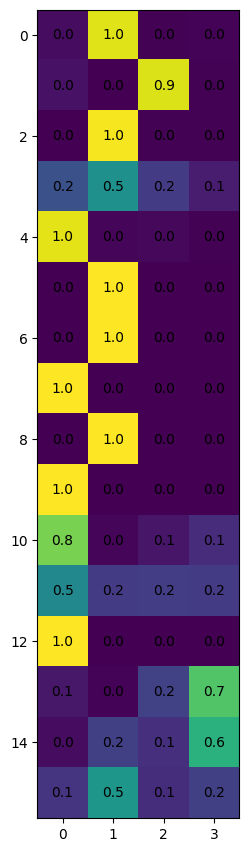

In [128]:
fig, ax1 = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(softmax(state_action_logprobs, 1).reshape(16, 4))

for (j,i), label in np.ndenumerate(softmax(state_action_logprobs, 1).reshape(16, 4).round(1)):
    ax1.text(i,j,label,ha='center',va='center')

Every row here represents different state and every action represents different action.

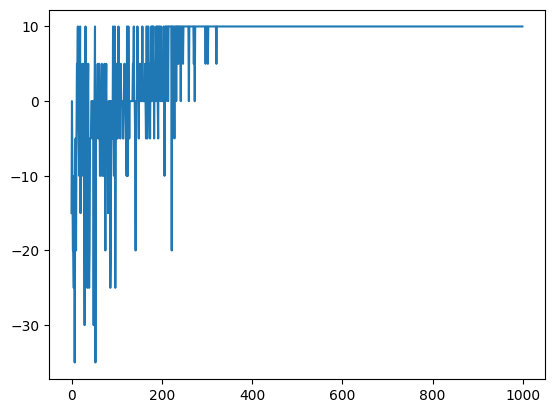

In [129]:
plt.plot(score_log)

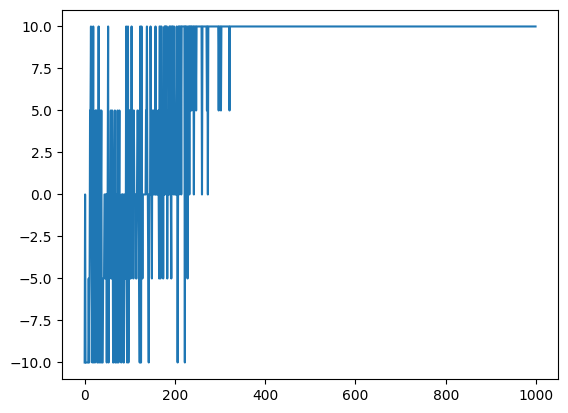

In [130]:
plt.plot(np.clip(score_log,-10,20))

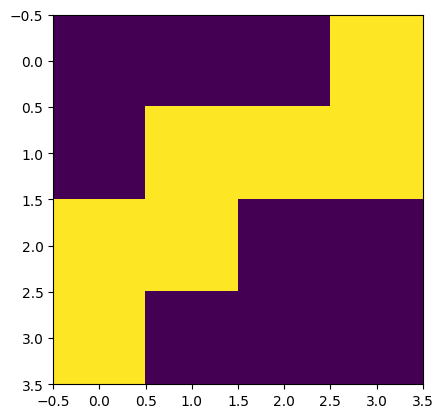

In [131]:
_, state_log = test_agent() # state_log stores the states visited by the test_agent()
state_view = np.zeros(16) # Initializing a state_view array to view the states visited by the test agent
state_view[state_log] = 1 # Setting the value of the states visited by the test agent as 1
plt.imshow(state_view.reshape(4,4))

# Testing loop over different trajectories

In [132]:
# Testing over different trajectories
test_score_log = []
number_of_test_trajectories = 1000
total_test_rewards_in_a_traj = 0

for _ in range(number_of_test_trajectories):
    test_state = 12 # Starting with the initial state
    test_state_log = []
    test_reward_log = []
    test_action_log = []
    test_values_log = []

    test_steps = 0

    # This while logic to finish the current trajectory from the initial position to the goal state
    while (not(test_state == 3)) and test_steps<100:
        test_action = np.argmax(softmax(state_action_logprobs[test_state]))
        #test_action = np.argmax(np.random.multinomial(1, softmax(state_action_logprobs[test_state]), size=1))

        # Taking the softmax of all the log probs of all actions in the given state.
        # IMP: We are using np.random.multinomial to give us a one hot encoder of selected action from all the actions
        # We are using a random selection rather than taking the max value to ensure exploration

        test_state_log.append(test_state) # log the current state
        test_action_log.append(test_action) # Log the current action

        test_state = state_transition_table[test_state, test_action] # Updating state based on the action taken
        test_steps += 1
        total_test_rewards_in_a_traj += rewards[test_state]


    test_score_log.append(total_test_rewards_in_a_traj)
    test_state_log.append(test_state)
    total_test_rewards_in_a_traj = 0



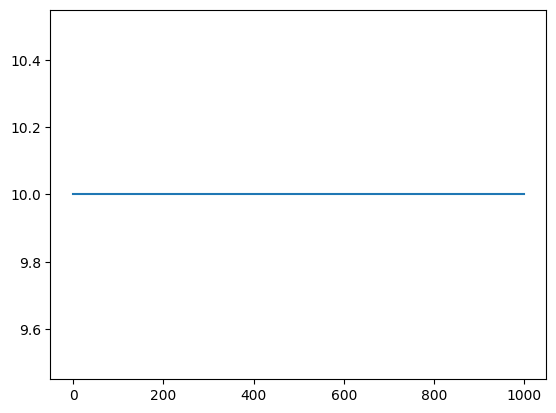

In [133]:
plt.plot(test_score_log)

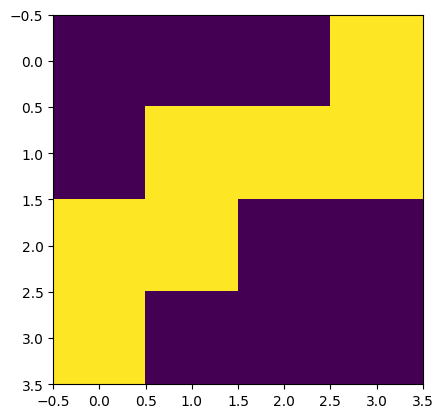

In [134]:
test_state_view = np.zeros(16) # Initializing a state_view array to view the states visited by the test agent
test_state_view[test_state_log] = 1 # Setting the value of the states visited by the test agent as 1
plt.imshow(test_state_view.reshape(4,4))